In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.conv_learner import *
from fastai.torch_imports import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [2]:
PATH = "data/dogbreeds/"

In [3]:
arch = resnext50
sz = 224
bs = 64

In [4]:
labels_csv = f'{PATH}labels.csv'
n = len(list(open(labels_csv)))-1
val_idxs = get_cv_idxs(n)

In [5]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', labels_csv, bs=bs, tfms=tfms, 
                                        val_idxs=val_idxs, suffix='.jpg', test_name='test')
    return data if sz < 300 else data.resize(340, 'tmp')

In [40]:
# data = get_data(sz, bs)

# labels_df = pd.read_csv(labels_csv)
# labels_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)
# fn = PATH + data.trn_ds.fnames[0]
# PIL.Image.open(fn)

# size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [41]:
# row_sz, col_sz = list(zip(*size_d.values()))
# row_sz, col_sz = np.array(row_sz), np.array(col_sz)

# plt.hist(row_sz[row_sz < 1000]); plt.hist(col_sz[col_sz < 1000]);

In [6]:
from sklearn import metrics

In [44]:
data = get_data(sz, bs)
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 162/162 [03:39<00:00,  1.35s/it]


A Jupyter Widget

 93%|█████████▎| 119/128 [00:01<00:00, 114.50it/s, loss=12.1]


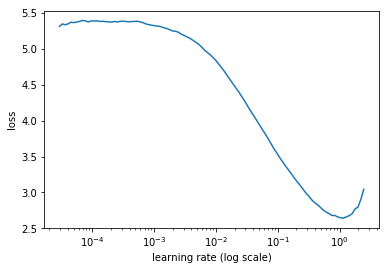

In [49]:
learn.lr_find()
learn.sched.plot()

In [50]:
learn.fit(2e-2, 2)

A Jupyter Widget

[ 0.       0.85798  0.39835  0.88994]                         
[ 1.       0.42135  0.31747  0.90664]                         



In [51]:
learn.fit(2e-2, 2)

A Jupyter Widget

[ 0.       0.27853  0.30884  0.90023]                         
[ 1.       0.21362  0.29688  0.90758]                         



In [55]:
learn.precompute=False
learn.fit(2e-2, 2)

A Jupyter Widget

[ 0.       0.31715  0.30835  0.89971]                        
[ 1.       0.27991  0.29524  0.90947]                        



In [56]:
learn.save('RNx50_224_pre')

In [11]:
# increasing size - taking advtg of Fully-Convolutional Arch
learn.set_data(get_data(299, 48))

In [65]:
learn.fit(1e-2, 3, cycle_len=1)

A Jupyter Widget

[ 0.       0.26006  0.24794  0.92193]                        
[ 1.       0.23345  0.23904  0.92906]                        
[ 2.       0.21016  0.23497  0.93182]                        



In [69]:
learn.save('RNx50_224_pre')

In [8]:
data  = get_data(299, 48)
learn = ConvLearner.pretrained(arch, data)
learn.load('RNx50_224_pre')

In [10]:
learn.freeze()

In [12]:
log_preds, y = learn.TTA()
probs = np.exp(log_preds)
accuracy(log_preds, y), metrics.log_loss(y, probs)


100%|██████████| 4/4 [05:57<00:00, 89.41s/it]
                                             

(0.92906066536203524, 0.22787421921797549)

In [13]:
test_preds = np.exp(learn.TTA(is_test=True)[0])


100%|██████████| 4/4 [29:23<00:00, 440.87s/it]
                                              

---

Rerunning without validation for predictions:

In [ ]:
from sklearn import metrics
PATH = "data/dogbreeds/"
arch = resnext50
sz = 224
bs = 64
labels_csv = f'{PATH}labels.csv'
# n = len(list(open(labels_csv)))-1
val_idxs = get_cv_idxs(0)
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', labels_csv, bs=bs, tfms=tfms, 
                                        val_idxs=val_idxs, suffix='.jpg', test_name='test')
    return data if sz < 300 else data.resize(340, 'tmp')

In [ ]:
data = get_data(sz, bs)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-2, 2)
learn.precompute=False
learn.fit(1e-2, 5, cycle_len=1)
learn.set_data(get_data(299, bs=32))
learn.fit(1e-2, 3, cycle_len=1)
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)